In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics # torchmetrics for easy metric computation
import pytorch_lightning as pl # pytorch lightning for efficient and easy training implementation
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import TensorBoardLogger # ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.device_count(), "GPUs available")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

2 GPUs available
GPU 0: Tesla T4
GPU 1: Tesla T4


In [3]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [4]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])

In [5]:
train_dataset = torchvision.datasets.DatasetFolder(
    "/kaggle/input/preprocessed/Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "/kaggle/input/preprocessed/Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)

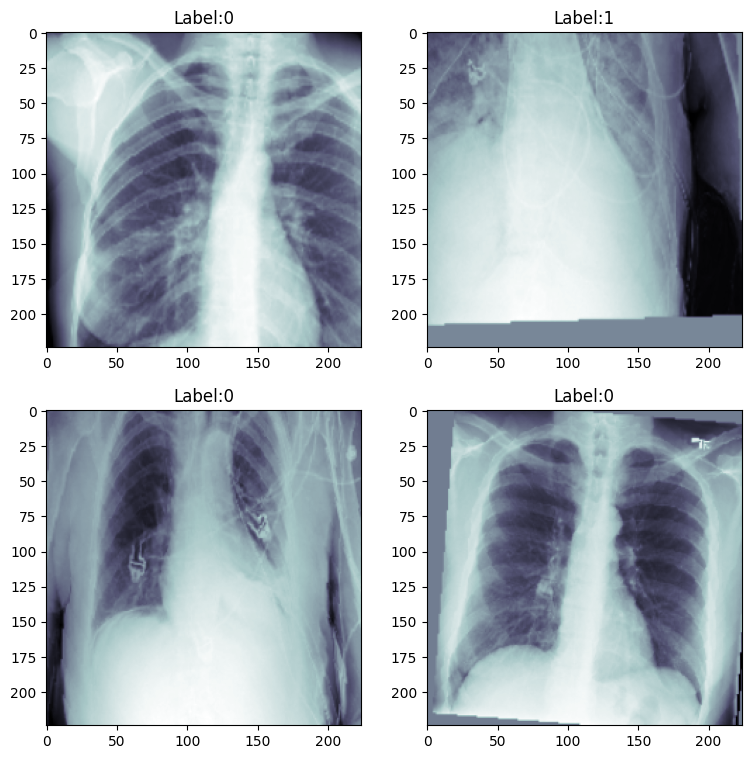

In [6]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [7]:
batch_size = 64#TODO
num_workers = 4# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


In [8]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

In [9]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
import torch
import torch.nn as nn
import torchmetrics
import torchvision
import pytorch_lightning as pl

class PneumoniaModel(pl.LightningModule):
    
    def __init__(self, weight=1):
        super().__init__()
        
        # Base model
        self.model = torchvision.models.resnet18(weights=None)  # Avoid pretrained RGB weights
        # Change first conv from 3 channels (RGB) to 1 channel (grayscale)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Change output to single logit for binary classification
        self.model.fc = nn.Linear(in_features=512, out_features=1)
        
        # Loss function with class imbalance handling
        self.register_buffer("pos_weight", torch.tensor([18593 / 5407]))  # positive/negative ratio
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        
        # Metrics for binary classification
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

    def forward(self, data):
        # Optional device check
        if not hasattr(self, 'device_logged'):
            print(f"Running model on device: {data.device}")
            self.device_logged = True
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray).squeeze(1)  # shape: (batch,)
        loss = self.loss_fn(pred, label)
        
        # Update and log step accuracy
        self.train_acc.update(torch.sigmoid(pred), label.int())
        self.log("Train Loss", loss, prog_bar=True)
        self.log("Step Train Acc", self.train_acc, prog_bar=True, on_step=True, on_epoch=False)
        return loss

    def on_train_epoch_end(self):
        # compute and log train accuracy
        self.log("Train Acc", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()
        
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray).squeeze(1)
        loss = self.loss_fn(pred, label)
        
        # Update and log step accuracy
        self.val_acc.update(torch.sigmoid(pred), label.int())
        self.log("Val Loss", loss, prog_bar=True)
        self.log("Step Val Acc", self.val_acc, prog_bar=True, on_step=True, on_epoch=False)
        return loss
    
    def on_validation_epoch_end(self):
        # compute and log val accuracy
        self.log("Val Acc", self.val_acc.compute(), prog_bar=True)
        self.val_acc.reset()
    
    def configure_optimizers(self):
        return [self.optimizer]



In [11]:
model = PneumoniaModel()

In [12]:
model

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [13]:
import os

# Ensure directory exists
ckpt_dir = "/kaggle/working/weights"
os.makedirs(ckpt_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=ckpt_dir,
    filename="weights_{epoch}_{Val Acc:.4f}",
    monitor='Val Acc',
    save_top_k=10,
    mode='max'
)

In [14]:
if torch.cuda.is_available():
    accelerator = "gpu"
    devices = "auto"
    precision = 16
else:
    accelerator = "cpu"
    devices = 1
    precision = 32

trainer = pl.Trainer(
    accelerator=accelerator,
    devices=devices,
    precision=precision,
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    max_epochs=10
)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


In [15]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

2025-08-13 09:12:12.028575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755076332.377058      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755076332.479408      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Running model on device: cuda:0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Evaluation

In [16]:
import os

best_ckpt = checkpoint_callback.best_model_path
print("Best checkpoint:", best_ckpt)

# Detect GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model from best checkpoint
model = PneumoniaModel.load_from_checkpoint(best_ckpt, strict=False)
model = model.to(device)
model.eval()

Best checkpoint: /kaggle/working/weights/weights_epoch=4_Val Acc=0.8249.ckpt


PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [17]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

Running model on device: cuda:0


In [18]:
import torchmetrics

# Convert to correct types
preds = preds.float()
labels = labels.int()

# Compute metrics
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(task="binary")(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task="binary", threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc:.4f}")
print(f"Val Precision: {precision:.4f}")
print(f"Val Recall: {recall:.4f}")
print(f"Confusion Matrix:\n{cm}")
print(f"Confusion Matrix (threshold=0.25):\n{cm_threshed}")


Val Accuracy: 0.8253
Val Precision: 0.5909
Val Recall: 0.7306
Confusion Matrix:
tensor([[1773,  306],
        [ 163,  442]])
Confusion Matrix (threshold=0.25):
tensor([[1396,  683],
        [  57,  548]])


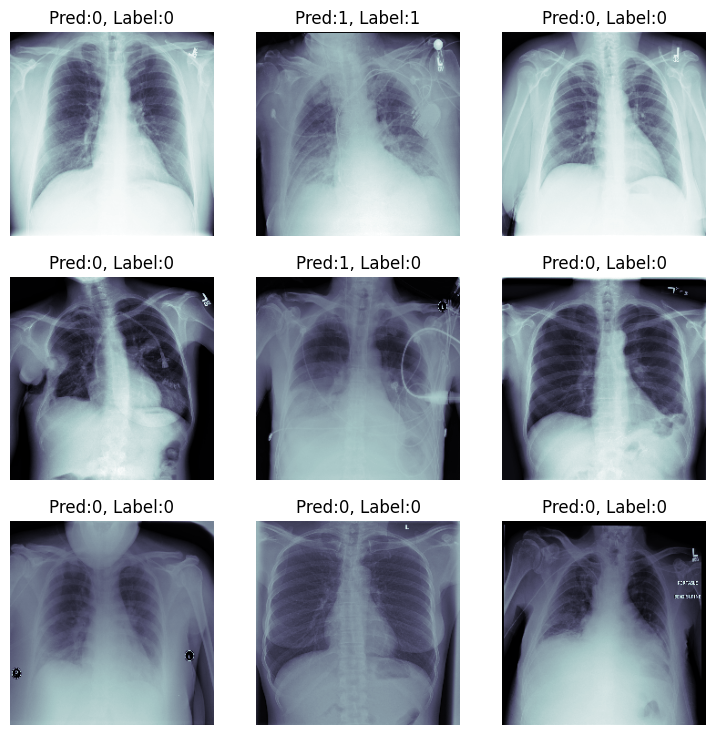

In [19]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")